In [2]:
import os
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.rcParams['figure.figsize'] = (16./3, 9./3)

def visualize_l2(pred, x_train, y_train, x_test, y_test):
    from matplotlib.patches import Rectangle
    plt.plot(x_train, y_train, '.k', markerfacecolor='none', label='Train Data')
    plt.plot(x_train, pred,  '--k', label='Model')
    plt.plot(x_test, y_test, 'xk', markersize=3, markerfacecolor='none', label='Test Data')
    currentAxis = plt.gca()
    for k, (xx,yy) in enumerate(zip(x_train, y_train)):
        error = pred[k] - yy
        currentAxis.add_patch(Rectangle((xx, yy), 
                                        error, error,
                              alpha=0.1, facecolor='gray', edgecolor='k'))
    plt.grid()
    plt.legend()
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')

In [4]:
# 데이터 생성
np.random.seed(327)
x_train = np.linspace(-1,1,50)
y_train = x_train**3 + 0.1 * x_train**2 -0.15 * x_train + 1.0 + 0.5 * np.random.rand(len(x_train))
x_test = np.linspace(-1,1,50)
y_test = x_test**3 + 0.1 * x_test**2 -0.15 * x_test + 1.0 + 0.5 * np.random.rand(len(x_test))

# 특성값 정의
features_train = np.array([[xval] for xval in x_train])
labels_train = y_train.reshape(-1, 1)
features_test = np.array([[xval] for xval in x_test])
labels_test = y_test.reshape(-1, 1)

In [5]:
# Regularization에 사용될 상수
beta = 1E-5
l2_reg = tf.contrib.layers.l2_regularizer(beta)

num_hidden1 = 10
num_hidden2 = 5

# 입력층
x = tf.placeholder(tf.float32, shape=[None, 1])
rand_init = tf.random_normal_initializer(seed=624)

with tf.variable_scope('TF_API'):
    # 은닉층 1
    hidden1 =  tf.contrib.layers.fully_connected(x, num_hidden1,
                                      activation_fn=tf.nn.sigmoid,
                                      weights_initializer=rand_init,
                                      biases_initializer=rand_init,
                                      weights_regularizer=l2_reg)

    # 은닉층 2
    hidden2 =  tf.contrib.layers.fully_connected(hidden1, num_hidden2,
                                      activation_fn=tf.nn.sigmoid,
                                      weights_initializer=rand_init,
                                      biases_initializer=rand_init,
                                      weights_regularizer=l2_reg)


    # 출력층
    yhat =  tf.contrib.layers.fully_connected(hidden2, 1,
                                      activation_fn=None,
                                      weights_initializer=rand_init,
                                      biases_initializer=rand_init,
                                      weights_regularizer=l2_reg)

# Regularization Term
reg_ws = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 'TF_API')

# 손실함수
y = tf.placeholder(tf.float32, shape=[None, 1])
loss = tf.losses.mean_squared_error(y, yhat) + tf.reduce_sum(reg_ws)

In [6]:
# Saver 함수
saver = tf.train.Saver()

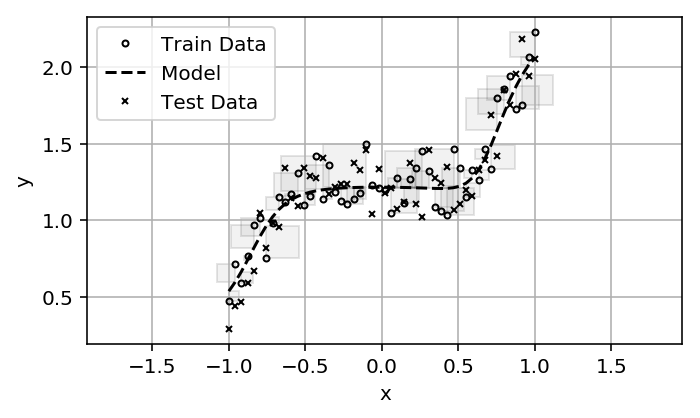

In [7]:
# 수치최적화 알고리즘
MaxEpoch = 4000
lr = 0.1
batch_size = 10
optimizer = tf.train.AdamOptimizer(lr)
train = optimizer.minimize(loss)

# 데이터 섞기
np.random.seed(320)
shuffled_id = np.arange(0, len(x_train))
np.random.shuffle(shuffled_id)
shuffled_x_train = features_train[shuffled_id]
shuffled_y_train = labels_train[shuffled_id]

# 스토캐스틱 방법
from helper import generate_batches
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(MaxEpoch+1):
        for x_batch, y_batch in generate_batches(batch_size, 
                                                 shuffled_x_train, 
                                                 shuffled_y_train):
            sess.run(train, feed_dict={x:x_batch, y:y_batch})
    
    # 모델 저장하기
    saver.save(sess, './checkpoints/nn_regression_model.ckpt')
    
    #그리기
    pred = sess.run(yhat, feed_dict={x:features_train, y:labels_train})
    visualize_l2(pred, x_train, y_train, x_test, y_test)
    plt.show()

INFO:tensorflow:Restoring parameters from ./checkpoints/nn_regression_model.ckpt


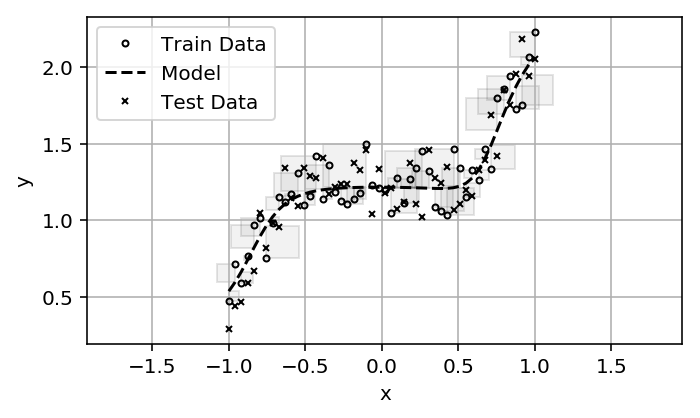

In [8]:
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, './checkpoints/nn_regression_model.ckpt')
    
    pred = sess.run(yhat, feed_dict={x:features_train, y:labels_train})
    visualize_l2(pred, x_train, y_train, x_test, y_test)
    plt.show()

In [9]:
plt.rcParams['figure.figsize'] = (16./3, 9./3)

def plot_model(sess, model, xy, labels, xy_test, labels_test, feature_lambda, title=''):
    from pandas import DataFrame
    xx, yy = np.meshgrid(np.linspace(-1.2,1.2,400), np.linspace(-1.2,1.2,400))
    prediction = sess.run(model, feed_dict={x: np.array([feature_lambda(xxval, yyval) for xxval, yyval in zip(xx.flatten(), yy.flatten())])})
    Z = prediction.reshape(xx.shape)
    df = DataFrame(dict(x=xy[:,0], y=xy[:,1], label=labels.flatten()))
    markers = {0:'bs', 1:'r^'}
    _, ax = plt.subplots(figsize=(5, 5))
    predictions = sess.run(model, feed_dict={x: xy})
    for k, xy0 in df[['x', 'y']].iterrows():
        x0, y0 = xy0.values
        plt.plot(x0, y0, markers[labels[k][0]], mec='k')
        
    df = DataFrame(dict(x=xy_test[:,0], y=xy_test[:,1], label=labels_test.flatten()))
    markers = {0:'bs', 1:'r^'}
    cs = ax.contourf(xx, yy, Z, 20, cmap='coolwarm', alpha=.9)
    ax.clabel(cs, colors='gray')
    cs = ax.contour(xx, yy, Z, cmap='gray', levels=[0, 0.5, 1.0], linestyles='--', linewidths=2)
    ax.clabel(cs, colors='k')
    predictions = sess.run(model, feed_dict={x: xy})
    for k, xy0 in df[['x', 'y']].iterrows():
        x0, y0 = xy0.values
        plt.plot(x0, y0, markers[labels[k][0]], mec='none')
        
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    plt.grid(linestyle='--', alpha=0.5)
    plt.title(title)
    plt.show()

In [10]:
from sklearn.datasets import make_circles

# 학습용 데이터 생성
xy_train, labels_train = make_circles(n_samples=50, noise=0.1, random_state=717)
labels_train = labels_train.reshape(-1,1)

# 테스트용 데이터 생성
xy_test, labels_test = make_circles(n_samples=50, noise=0.1, random_state=712)
labels_test = labels_test.reshape(-1,1)

In [11]:
# 특성값 추출
f_fn = lambda x,y: [x, y]
features = np.array([f_fn(xval, yval) for xval, yval in xy_train])
features_test = np.array([f_fn(xval, yval) for xval, yval in xy_test])
dim_features = features.shape[1]

# 예측모델
num_hidden1 = 10
num_hidden2 = 5

# 입력층
x = tf.placeholder(tf.float32, shape=(None, dim_features))
rand_init = tf.random_normal_initializer(seed=624)

# 은닉층 1
hidden1 =  tf.contrib.layers.fully_connected(x, num_hidden1,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)

# 은닉층 2
hidden2 =  tf.contrib.layers.fully_connected(hidden1, num_hidden2,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)

# 출력층
yhat =  tf.contrib.layers.fully_connected(hidden2, 1,
                                          activation_fn=tf.nn.sigmoid,
                                          weights_initializer=rand_init,
                                          biases_initializer=rand_init)

In [12]:
# 손실함수
y = tf.placeholder(tf.float32, shape=(None, 1))
loss = tf.reduce_mean(-y * tf.log(yhat) - (1-y) * tf.log(1-yhat))

# 정확도
correct_prediction = tf.equal(y, tf.round(yhat))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [13]:
saver = tf.train.Saver(max_to_keep=40)

# 수치최적화 알고리즘
lr = 0.5
optimizer = tf.train.GradientDescentOptimizer(lr)
train = optimizer.minimize(loss)

from helper import generate_batches
# 데이터 섞기
np.random.seed(7382)
idx = np.arange(0, len(features))
np.random.shuffle(idx)
shuffled_features = features[idx]
shuffled_labels = labels_train[idx]

# Log Step
it = 0

# 스토캐스틱 방법
MaxEpochs = 4000
batch_size = 10
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for epoch in range(MaxEpochs+1):
    for x_batch, y_batch in generate_batches(batch_size, 
                                             shuffled_features, 
                                             shuffled_labels):
        sess.run(train, feed_dict={x: x_batch, y: y_batch})
        
    if epoch % 100 == 0:
        saver.save(sess, 'checkpoints/nn_binary_classifcation.ckpt', 
                   global_step=epoch)

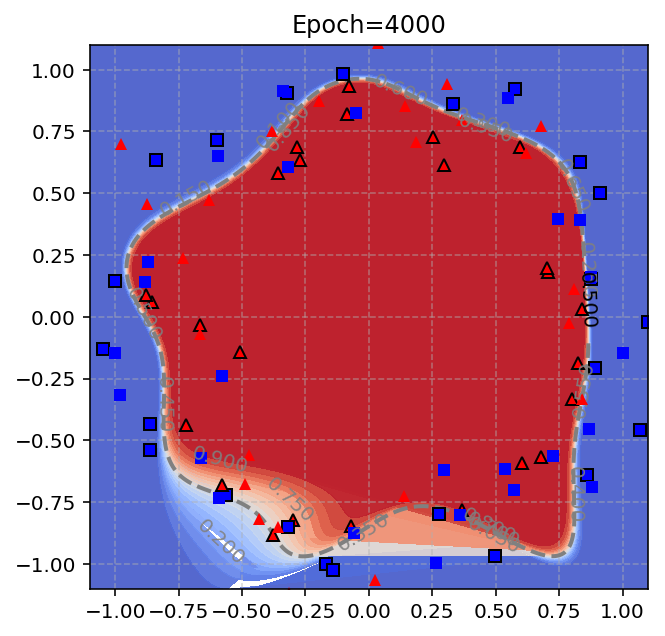

In [14]:
plot_model(sess, yhat, xy_train, labels_train, xy_test, labels_test, f_fn, 'Epoch={}'.format(epoch))

INFO:tensorflow:Restoring parameters from checkpoints/nn_binary_classifcation.ckpt-100


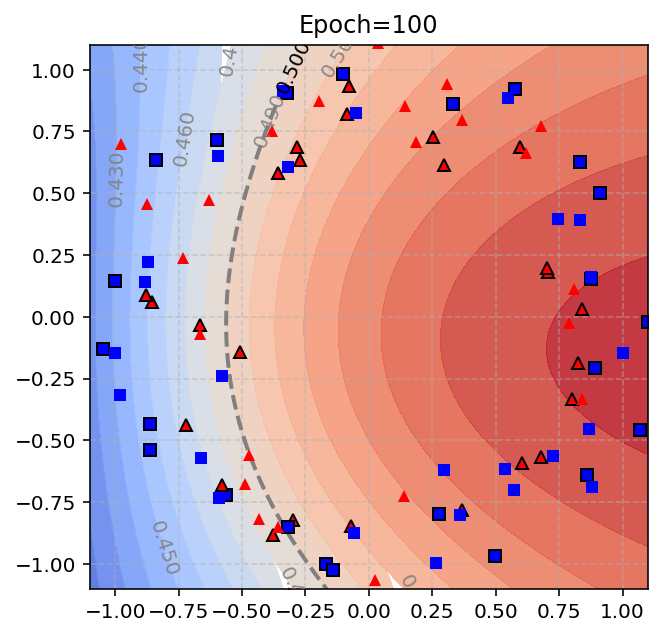

In [15]:
myEpoch = 100
saver.restore(sess, 'checkpoints/nn_binary_classifcation.ckpt-{}'.format(myEpoch))
plot_model(sess, yhat, xy_train, labels_train, xy_test, labels_test, f_fn, 'Epoch={}'.format(myEpoch))

INFO:tensorflow:Restoring parameters from checkpoints/nn_binary_classifcation.ckpt-400


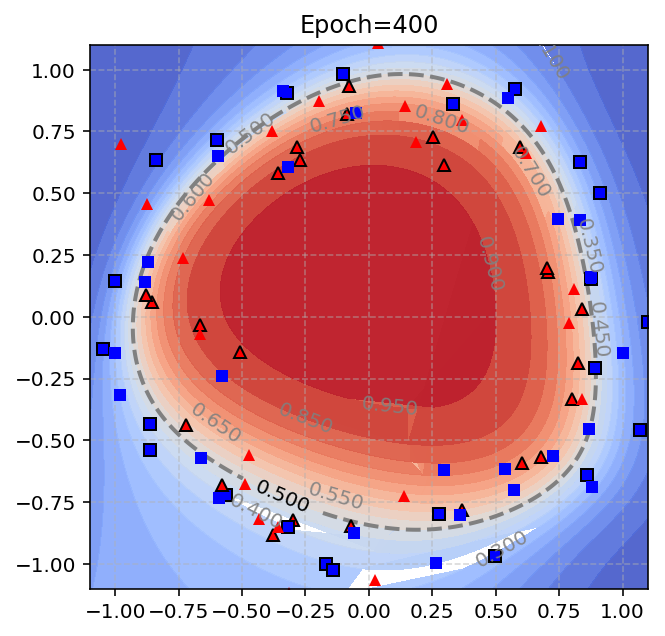

In [16]:
myEpoch = 400
saver.restore(sess, 'checkpoints/nn_binary_classifcation.ckpt-{}'.format(myEpoch))
plot_model(sess, yhat, xy_train, labels_train, xy_test, labels_test, f_fn, 'Epoch={}'.format(myEpoch))

INFO:tensorflow:Restoring parameters from checkpoints/nn_binary_classifcation.ckpt-800


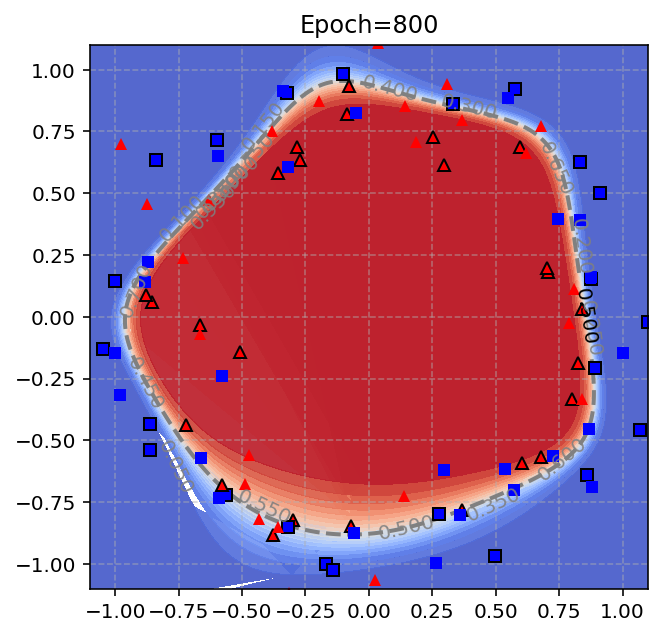

In [17]:
myEpoch = 800
saver.restore(sess, 'checkpoints/nn_binary_classifcation.ckpt-{}'.format(myEpoch))
plot_model(sess, yhat, xy_train, labels_train, xy_test, labels_test, f_fn, 'Epoch={}'.format(myEpoch))

INFO:tensorflow:Restoring parameters from checkpoints/nn_binary_classifcation.ckpt-1200


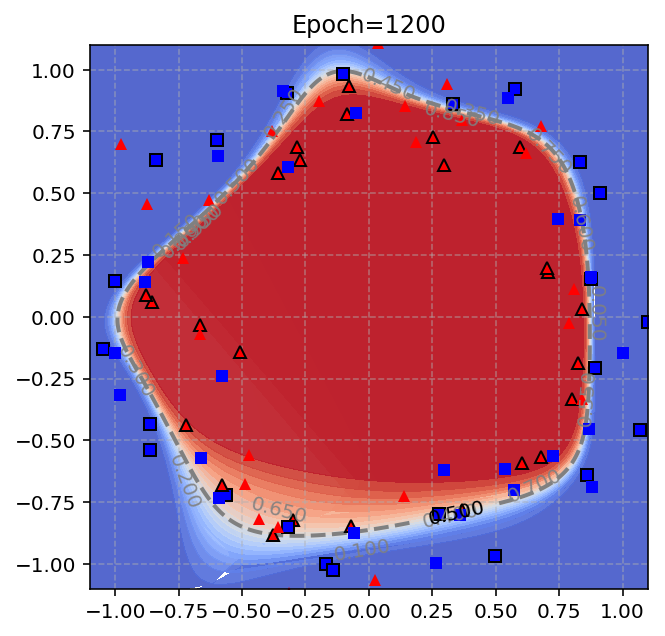

In [18]:
myEpoch = 1200
saver.restore(sess, 'checkpoints/nn_binary_classifcation.ckpt-{}'.format(myEpoch))
plot_model(sess, yhat, xy_train, labels_train, xy_test, labels_test, f_fn, 'Epoch={}'.format(myEpoch))